In [1]:
from functools import partial, cached_property
import numpy as np
import jax
import jax.random as jr
import jax.numpy as jnp
import jax.nn as jnn
import jax.tree_util as jtu
from jax.nn import sigmoid, log_softmax, relu
from jax import jit, vmap, grad, hessian, lax
from jax.scipy.linalg import cholesky, solve_triangular
from jax.example_libraries import optimizers
from jax.example_libraries import stax
import neural_tangents as nt
import tensorflow as tf
import equinox as eqx
import optax
from matplotlib import colors

ModuleNotFoundError: jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_moons
import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)

import sys
sys.path.insert(0, 'lib')



def func(x, noise=True):
    x = x + 1e-6
    fun =  np.sin(x*5)/x  + np.cos(x*10) #+ x**2 +np.log(5*x + 0.00001)  + 0.5 
    if noise == True:
        fun = fun + np.random.normal(size=(x.shape),scale=0.4)   
    return fun

seed = 123
np.random.seed(seed)

X_lin = jnp.linspace(0,2,100)[:,jnp.newaxis]
X = jr.uniform(jr.PRNGKey(6), minval=0, maxval=2, shape=(100,1))
y = func(X, True)
X_test = jr.uniform(jr.PRNGKey(6), minval=0, maxval=2, shape=(50,1))
y_test = func(X_test)


#y = y.astype('float64')[:,None]
#y_test = y_test.astype('float64')[:,None]

y.shape, X.shape

((100, 1), (100, 1))

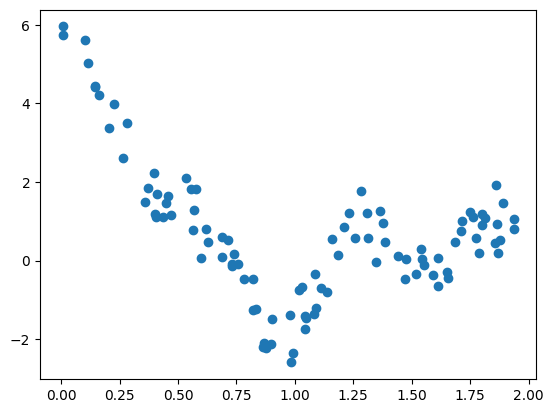

In [3]:
plt.scatter(X,y)

In [4]:
def eval_accuracy(logits, targets, multiclass=True):
    # if multiclass:
    #     return jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(targets, -1))
    # preds = jnp.heaviside(logits,0)
    return jnp.mean(logits == targets)

def train(model, nll_fn, optimizer, opt_state,
          n_updates,  delta, n_classes, data_stream,
          eval_frequency=10, _eval=False, data_stream_test=None):
    def accuracy(model, batch):
        inputs, targets = batch
        logits = jax.vmap(model, in_axes=(0))(inputs)
        return eval_accuracy(logits, targets, (n_classes > 1))

    def loss(model, batch):
        inputs, targets = batch
        logits = jax.vmap(model, in_axes=(0))(inputs)
        l2_norm_v = l2_norm(model)
        loss_val = nll_fn(logits, targets) + delta * l2_norm_v 
        return loss_val, l2_norm_v

    @eqx.filter_jit
    def update(model, opt_state, batch):
        (loss_val, l2_norm_v), grads = eqx.filter_value_and_grad(loss, has_aux=True)(model, batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_val

    for ii in range(n_updates):
        x_batch, y_batch = next(data_stream)
        model, opt_state, loss_val = update(model, opt_state,
                                   (x_batch, y_batch))
        #print(loss_val)
        
        
        # TODO: fix the evaluation part rn is using directly X,y and X_test,y_test
        if (ii+1) % eval_frequency == 0:
                print(f"Iter: {ii + 1:5d} / {n_updates}  : loss: {loss_val:.4f} " \
                    f"train-acc: {accuracy(model, (X, y)):.3f}  " +
                    (f"test-acc: {accuracy(model, (X_test, y_test)):.3f}" if _eval else ""))
    return model


In [5]:
## Global Constants
EPS = 1e-7 # clipping for numerical stability
learning_rate = 0.01
n_updates = 2500
delta = 0.005
seed = 36
batch_size = X.shape[0]
## Losses

def mse(logits, targets):
    return 0.5*jnp.square(logits-targets).mean()

## Utils
def l2_norm(model):
    params = eqx.filter(model, eqx.is_array)
    return 0.5 * sum(jnp.sum(jnp.square(p)) for p in jtu.tree_leaves(params))

def get_data_stream(x, y, batch_size=64, is_training=True, seed=1):
    if batch_size == -1 or batch_size > x.shape[0]:
        batch_size = x.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    if is_training:
        dataset = dataset.shuffle(10*batch_size, seed, reshuffle_each_iteration=True) # heuristic for shuffle buffer ratio
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset.as_numpy_iterator()

In [6]:
from jax.nn.initializers import glorot_normal, normal
import math

def init_mlp(net, key):
    net_params, static = eqx.partition(net, eqx.is_array)
    params, tree_def = jtu.tree_flatten(net)
    new_params = []
    
    w_initializer = glorot_normal()
    b_initializer = normal()
    
    for param in params:
        if isinstance(param, jnp.ndarray) and not (
                param.size == 1 and isinstance(param.item(), bool)
        ):
            if len(param.shape) > 1:
                # Initialize weigths
                wkey, key = jr.split(key)
                new_param = w_initializer(wkey, param.shape, jnp.float32)
                new_params.append(new_param)
                #out_size, in_size = param.shape
                #std = 1.0 * math.sqrt(2.0 / (in_size + out_size))
                #lim = math.sqrt(3.0) * std
                #new_params.append(jr.uniform(wkey, shape=param.shape,
                #                              minval=-lim, maxval=lim))
            else:
                # Initialize bias
                bkey, key = jr.split(key)
                new_param = b_initializer(bkey, param.shape, jnp.float32)
                new_params.append(new_param)
                #new_params.append(jnp.zeros_like(param))
        else:
            new_params.append(param)

    net_params = jtu.tree_unflatten(tree_def, new_params)
    return eqx.combine(net_params, static)



In [7]:
def make_mlp(in_size, out_size, width_size, depth, activation, *, key):
    mlp = eqx.nn.MLP(
        in_size, out_size, width_size, depth, activation,  key=key)
    mlp = init_mlp(mlp, key)
    params, static = eqx.partition(mlp, eqx.is_array)
    
    def init_fn():
        return params
    
    def apply_fn(_params, x):
        model = eqx.combine(_params, static)
        return model(x)
    
    def apply_fn_vmap(_params, x):
        model = eqx.combine(_params, static)
        return eqx.filter_jit(vmap(model, in_axes=0))(x)
    
    def get_model(_params):
        return eqx.combine(_params, static)

    return init_fn, apply_fn, apply_fn_vmap, get_model, mlp

In [8]:
## Global Constants
EPS = 1e-7 # clipping for numerical stability
learning_rate = 0.01
n_updates = 2500
delta = 0.0001
seed = 36
batch_size = X.shape[0]

## Model
key = jr.PRNGKey(123)
key, key_model = jr.split(key)
in_size = X.shape[1]
out_size = y.shape[1]
width_size = 25
activation = jnn.tanh#jnp.sin#jnn.sigmoid#jnn.tanh
depth = 3
# init_fn, 
init_fn, apply_fn, apply_fn_vmap, get_model, model = make_mlp(
    in_size, out_size, width_size, depth, activation, key=key_model
)

#model = eqx.nn.MLP(
#        in_size, out_size, width_size, depth, activation,  key=key_model)

In [9]:
data_stream = get_data_stream(X, y, batch_size, seed)
batch_size_eval = 100
data_stream_test = get_data_stream(X_test, y_test, batch_size=batch_size_eval, is_training=False)
nll_fn = mse

## Optimizer 
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

model = train(model, nll_fn, optimizer, opt_state, n_updates, delta,
      y.shape[1], data_stream, _eval=True, data_stream_test=data_stream_test)

Iter:    10 / 2500  : loss: 1.2472 train-acc: 0.000  test-acc: 0.000
Iter:    20 / 2500  : loss: 0.9563 train-acc: 0.000  test-acc: 0.000
Iter:    30 / 2500  : loss: 0.5453 train-acc: 0.000  test-acc: 0.000
Iter:    40 / 2500  : loss: 0.4371 train-acc: 0.000  test-acc: 0.000
Iter:    50 / 2500  : loss: 0.3568 train-acc: 0.000  test-acc: 0.000
Iter:    60 / 2500  : loss: 0.3168 train-acc: 0.000  test-acc: 0.000
Iter:    70 / 2500  : loss: 0.2974 train-acc: 0.000  test-acc: 0.000
Iter:    80 / 2500  : loss: 0.2855 train-acc: 0.000  test-acc: 0.000
Iter:    90 / 2500  : loss: 0.2722 train-acc: 0.000  test-acc: 0.000
Iter:   100 / 2500  : loss: 0.2577 train-acc: 0.000  test-acc: 0.000
Iter:   110 / 2500  : loss: 0.2379 train-acc: 0.000  test-acc: 0.000
Iter:   120 / 2500  : loss: 0.2135 train-acc: 0.000  test-acc: 0.000
Iter:   130 / 2500  : loss: 0.1882 train-acc: 0.000  test-acc: 0.000
Iter:   140 / 2500  : loss: 0.1686 train-acc: 0.000  test-acc: 0.000
Iter:   150 / 2500  : loss: 0.1572

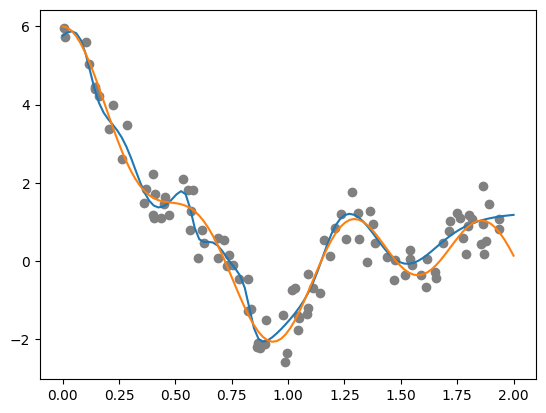

In [10]:
plt.scatter(X.squeeze(), y.squeeze(),color='grey')
plt.plot(X_lin, jax.vmap(model)(X_lin))
plt.plot(X_lin, func(X_lin,noise=False))

In [11]:
def lambdas_fn(nll_fn, logits_train, y, n_classes, clip_lambda=True):
    """In case of multiclass, this returns array with shape (N,K,K)"""
    lambdas = jit(vmap(hessian(nll_fn)))(logits_train, y)
    # for multiclass, lambdas shp (K,K); only clip diagonal
    if clip_lambda:
        if n_classes > 1:
            #diag_indices = jax.ops.index[:,
             #                            jnp.arange(lambdas.shape[1]),
              #                           jnp.arange(lambdas.shape[2])]
            diag_indices = jnp.index_exp[:,jnp.arange(lambdas.shape[1]),
                                         jnp.arange(lambdas.shape[2])]
        else:
            #diag_indices = jax.ops.index[:]
            diag_indices = jnp.index_exp[:]
        lambdas_diag = jnp.clip(lambdas[diag_indices], EPS)
        #lambdas = jax.ops.index_update(lambdas, diag_indices, lambdas_diag)
        lambdas = lambdas.at[diag_indices].set(lambdas_diag)
    return lambdas

In [12]:


def get_dual(d, model):
    X, y = d
    lambdas, y, x, params, delta = model
    
    gram = jnp.squeeze(kernel_fn(X, None, params))
    K = 1/(delta*X.shape[0]) * gram 
    
    A = lambdas**-1 * jnp.eye(gram.shape[0]) + K
    
    alpha_f = jnp.linalg.solve(A, y)
    beta_f = jnp.linalg.solve(lambdas**-1 * jnp.eye(gram.shape[0]) + K, jnp.eye(K.shape[0]))
    
    return alpha_f, beta_f

def pred(x_p, kernel, model, dual_p):
    lambdas, y, x, params, delta = model
    alpha, beta = dual_p
    
    gram_pp = jnp.squeeze(kernel(x_p, x_p, params))
    gram_px = jnp.squeeze(kernel(x_p, x, params))
    K_pp = 1/(delta*X.shape[0]) * gram_pp
    K_px = 1/(delta*X.shape[0]) * gram_px
    
    mean_f = K_px @ alpha
    var_f = K_pp  - K_px @ beta @ K_px.T
    var_f = jnp.diag(var_f)
    
    return mean_f, var_f
    

In [13]:
params, static = eqx.partition(model, eqx.is_array)

f = apply_fn_vmap(params, X)
# lambdas = lambdas_fn(nll_fn, f, y, n_classes=y.shape[1])
# alphas = alphas_fn(nll_fn, f, y)

kernel_fn = nt.empirical_ntk_fn(vmap(apply_fn, in_axes=(None, 0)), trace_axes=(), diagonal_axes=(1,), vmap_axes=0)


data = (X, y)
lambdas = lambdas_fn(nll_fn, f, y, n_classes=y.shape[1])
lambdas = lambdas.reshape(lambdas.shape[0], 1).squeeze()
m = (lambdas, y, X, params, delta)

X_lin = jnp.linspace(0,2.50,110)[:,jnp.newaxis]

a, b = get_dual(data, m)
du = (a, b)
ms, vs = pred(X_lin, kernel_fn, m, du)

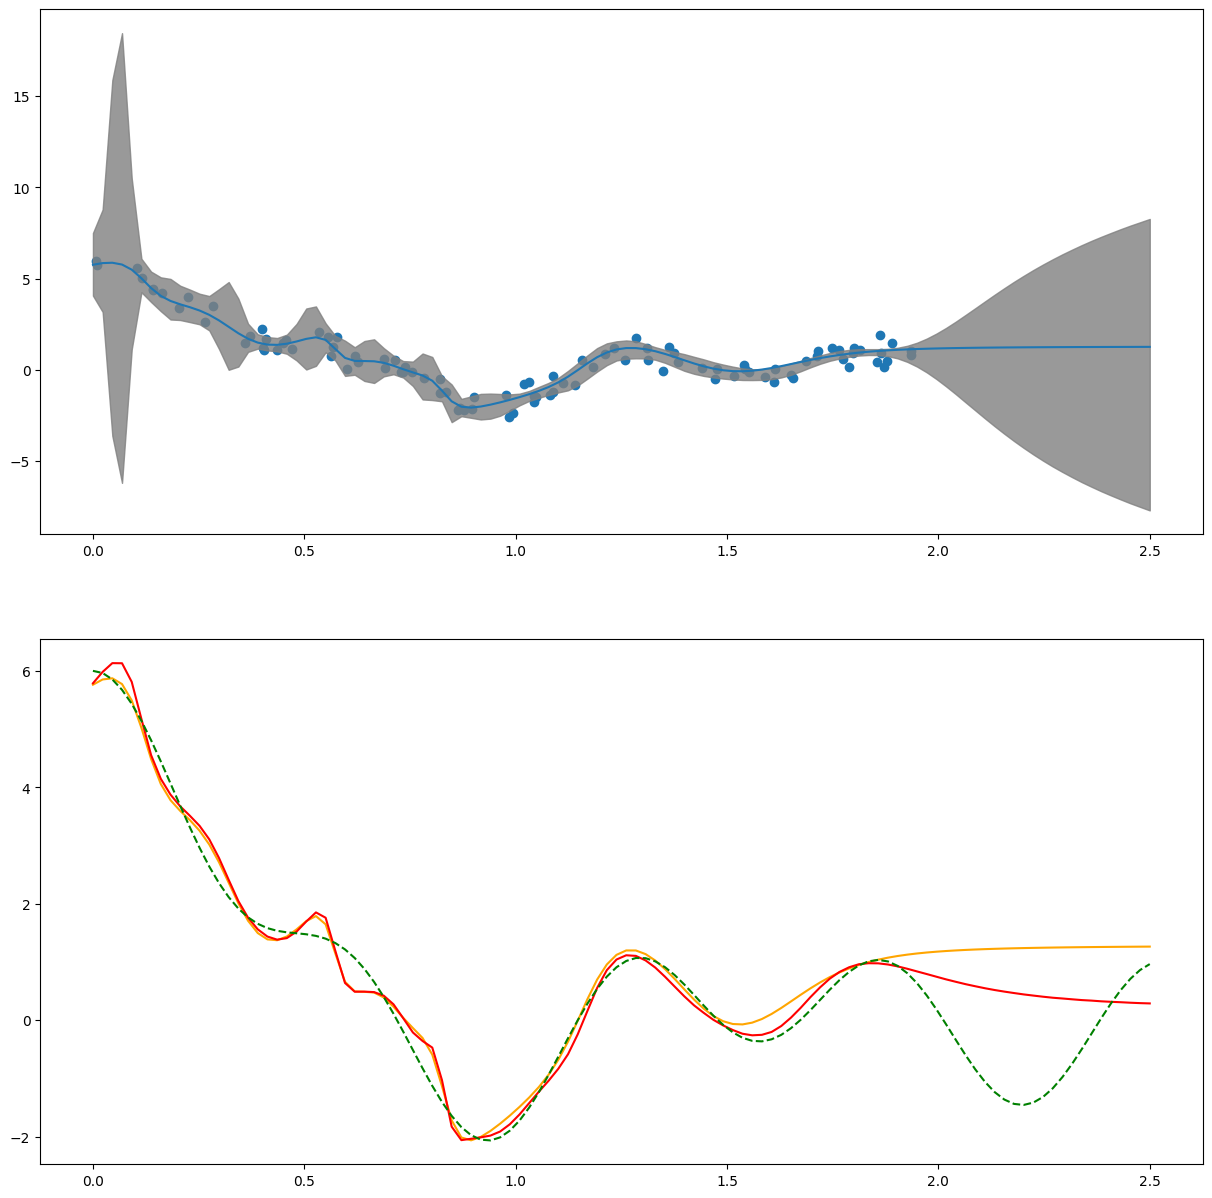

In [14]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))

f_lin = jax.vmap(model)(X_lin)
# ax1.plot(X,f_gp)
#ax1.plot(X,f)
ax1.scatter(X,y)


ax1.plot(X_lin,jax.vmap(model)(X_lin))
ax1.fill_between(jnp.squeeze(X_lin), jnp.squeeze(ms)-1.96*vs, jnp.squeeze(ms)+1.96*vs ,alpha=0.8,color='grey')

# ax1.fill_between(jnp.squeeze(X), jnp.squeeze(f_gp-1.96*var_gp_i), jnp.squeeze(f_gp+1.96*var_gp_i) ,alpha=0.8)

ax2.plot(X_lin,f_lin,color='orange')
ax2.plot(X_lin,ms, color='r')
ax2.plot(X_lin,func(X_lin,noise=False),'g--')

In [15]:
Z = jnp.linspace(0, 2.5,50)[:,jnp.newaxis]

# kzi = 1 / (delta*X.shape[0]) * kernel_fn(
#     Z, X, params).squeeze()
# kzz = 1 / (delta*X.shape[0]) * kernel_fn(
#     Z, Z, params).squeeze()

# A_zz = kzi @ (lambdas**-1 * jnp.eye(X.shape[0])) @ kzi.T
# beta_z = jnp.linalg.solve(kzz, jnp.eye(kzz.shape[0])) - jnp.linalg.solve(A_zz + kzz, jnp.eye(kzz.shape[0]))

lambs = (y, lambdas)

def get_dual_s(z, x, kernel, delta, lambs):
    
    lambda1, lambda2 = lambs 
    
    kzi = 1 / (delta*x.shape[0]) * kernel_fn(
        z, x, params).squeeze()


    A_zz = kzi @ (lambda2**-1 * jnp.eye(x.shape[0])) @ kzi.T
    a_zz = kzi @ lambda1
    
    return a_zz, A_zz

def dual_pred(sd, kernel, x_p, z):
    
    a_zz, A_zz = sd
    
    gram_pp = jnp.squeeze(kernel(x_p, x_p, params))
    gram_px = jnp.squeeze(kernel(x_p, z, params))
    K_pp = 1/(delta*X.shape[0]) * gram_pp
    K_pz = 1/(delta*X.shape[0]) * gram_px
    
    kzz = 1 / (delta*X.shape[0]) * kernel(
            Z, Z, params).squeeze()
    beta_z = jnp.linalg.solve(kzz, jnp.eye(kzz.shape[0])) - jnp.linalg.solve(A_zz + kzz, jnp.eye(kzz.shape[0]))
    var_f = K_pp - K_pz @ beta_z @ K_pz.T
    #var_f = jnp.diag(var_z)
    
    V = kzz @ jnp.linalg.solve(A_zz + kzz, kzz)
    m_u = V @ jnp.linalg.solve(kzz, jnp.eye(kzz.shape[0])) @ a_zz
    
    m_f = K_pz @ jnp.linalg.solve(kzz, jnp.eye(kzz.shape[0])) @ m_u
    
    return m_f, jnp.diag(var_f)
    
    
    

In [43]:
lambs = (y, lambdas)

dp = get_dual_s(Z, X, kernel_fn, delta, lambs)

m, v = dual_pred(dp, kernel_fn, X_lin, Z)


v.shape

(110,)

In [44]:
def alphas_fn(nll_fn, logits_train, y):
    return vmap(eqx.filter_grad(nll_fn))(logits_train, y)


logits_train = jax.vmap(model)(X)
alphas = alphas_fn(nll_fn, logits_train, y)

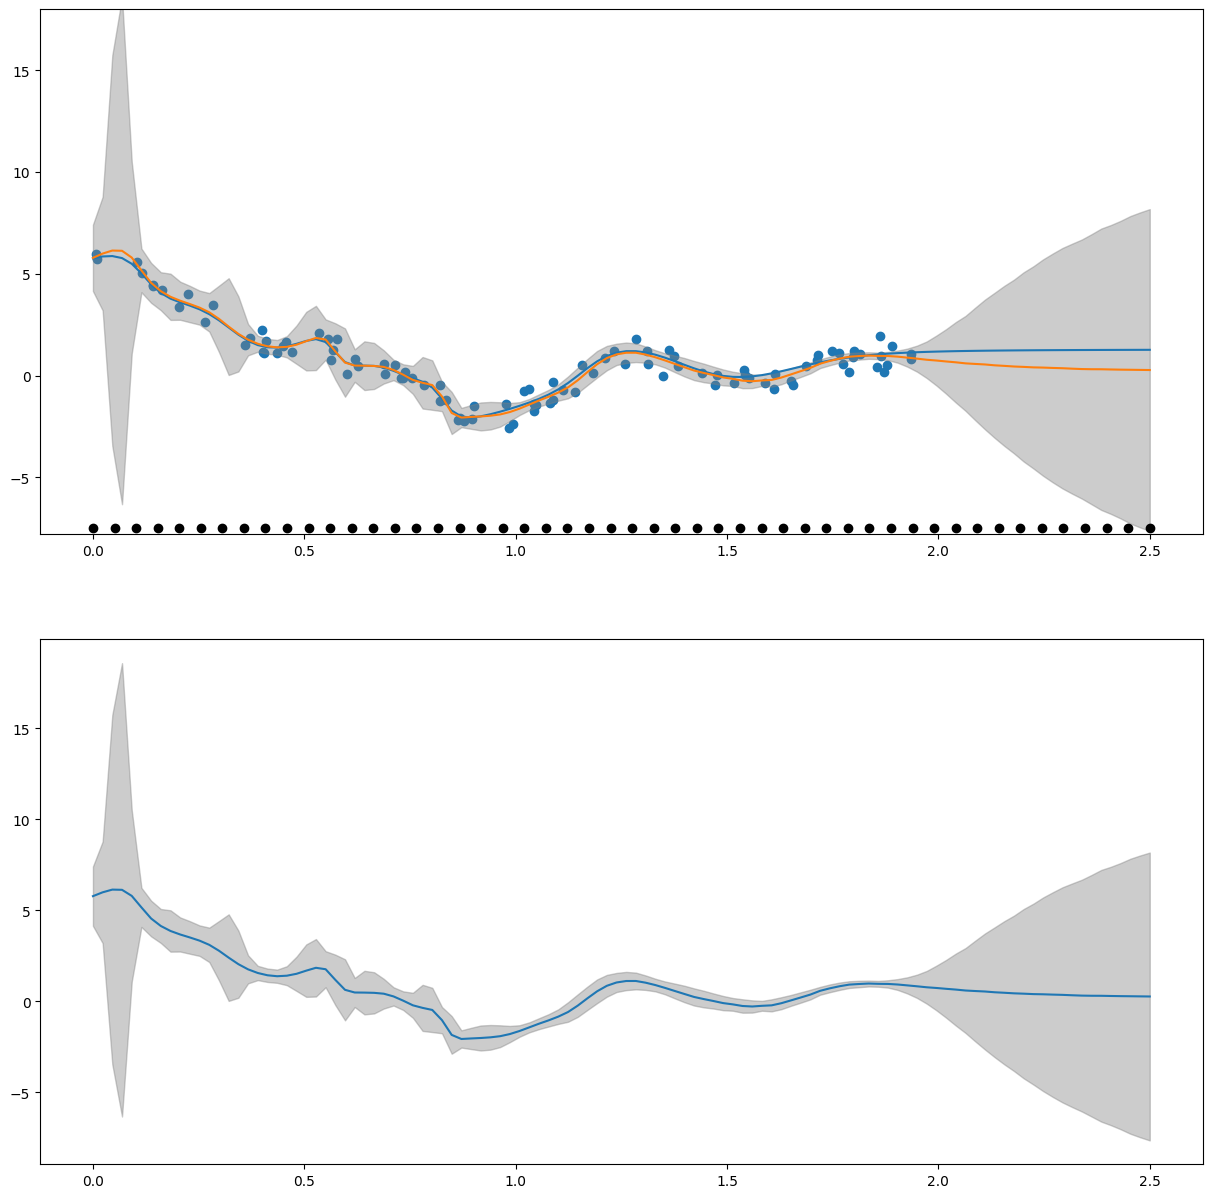

In [48]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))

f_lin = jax.vmap(model)(X_lin)
# ax1.plot(X,f_gp)
#ax1.plot(X,f)
ax1.scatter(X,y)


ax1.plot(X_lin,jax.vmap(model)(X_lin))
#ax1.fill_between(jnp.squeeze(X_lin), jnp.squeeze(ms)-1.96*vs, jnp.squeeze(ms)+1.96*vs ,alpha=0.8,color='grey')

ax1.plot(X_lin, m)
ax1.fill_between(jnp.squeeze(X_lin), jnp.squeeze(m)-1.96*v, jnp.squeeze(m)+1.96*v ,alpha=0.4,color='grey')

ax1.scatter(Z,jnp.zeros_like(Z)-7.5,color='black')
ax1.set_ylim([-7.8, 18])


ax2.plot(X_lin, m)
ax2.fill_between(jnp.squeeze(X_lin), jnp.squeeze(m)-1.96*v, jnp.squeeze(m)+1.96*v ,alpha=0.4,color='grey')

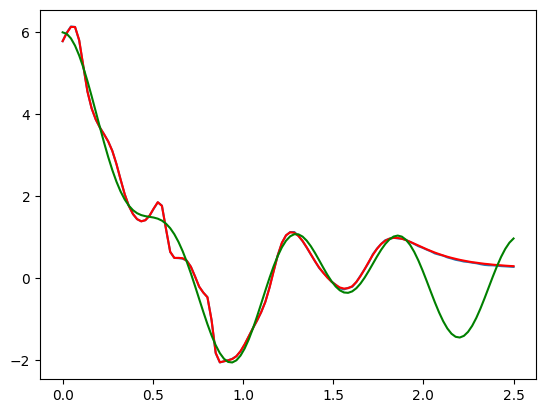

In [49]:
plt.plot(X_lin, m)
plt.plot(X_lin, ms, color='r')
plt.plot(X_lin, func(X_lin, noise=False), color='g')

In [66]:
X_test = jr.uniform(jr.PRNGKey(6), minval=2, maxval=2.2, shape=(15,1))
y_test = func(X_test)

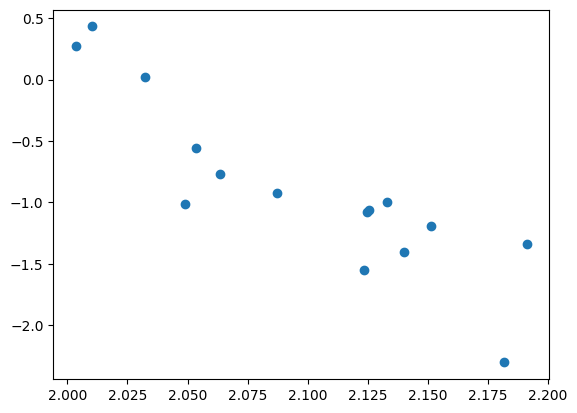

In [67]:
plt.scatter(X_test, y_test)

In [71]:
a_zz, A_zz = dp

kzi = 1 / (delta*X.shape[0]) * kernel_fn(
    Z, X_test, params).squeeze()

a_zz = a_zz + kzi @ y_test

A_zz = A_zz + kzi @ (1**-1 * jnp.eye(X_test.shape[0])) @ kzi.T

In [72]:
dp_u = (a_zz, A_zz)

mu, vu = dual_pred(dp_u, kernel_fn, X_lin, Z)



(-7.8, 18.0)

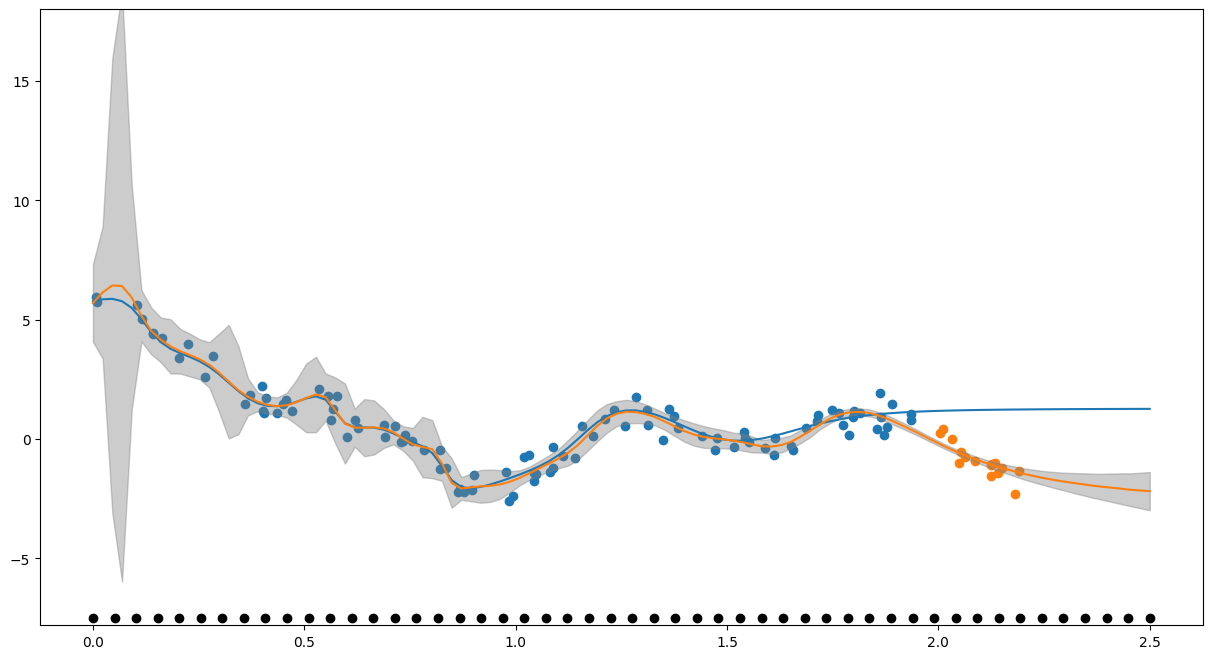

In [74]:
fig, ax1 = plt.subplots(1,figsize=(15, 8))

f_lin = jax.vmap(model)(X_lin)
# ax1.plot(X,f_gp)
#ax1.plot(X,f)
ax1.scatter(X,y)

ax1.scatter(X_test,y_test)

ax1.plot(X_lin,jax.vmap(model)(X_lin))
#ax1.fill_between(jnp.squeeze(X_lin), jnp.squeeze(ms)-1.96*vs, jnp.squeeze(ms)+1.96*vs ,alpha=0.8,color='grey')

ax1.plot(X_lin, mu)
ax1.fill_between(jnp.squeeze(X_lin), jnp.squeeze(mu)-1.96*vu, jnp.squeeze(mu)+1.96*vu ,alpha=0.4,color='grey')

ax1.scatter(Z,jnp.zeros_like(Z)-7.5,color='black')
ax1.set_ylim([-7.8, 18])